# Histograms
This notebook demonstrates simple use of histograms in WhiteNoise.

### Set up libraries and load exemplar dataset

In [1]:
# load libraries
import os
import whitenoise
import whitenoise.components as op
import numpy as np
import math
import statistics

# establish data information
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married"]

data = np.genfromtxt(data_path, delimiter=',', names=True)
age = list(data[:]['age'])

print("Dimension of dataset: " + str(data.shape))
print("Names of variables:   " + str(data.dtype.names))

Dimension of dataset: (1000,)
Names of variables:   ('age', 'sex', 'educ', 'race', 'income', 'married')


In [64]:
income_edges = list(range(0, 100000, 10000))
education_categories = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17"]


with whitenoise.Analysis() as analysis:
    data = whitenoise.Dataset(path = data_path, column_names = var_names)
        
    income_histogram = op.dp_histogram(
            op.cast(data['income'], type='int', min=0, max=100),
            edges = income_edges,
            count_max = 1000,
            null_value = 150,
            privacy_usage = {'epsilon': 1.}
        )

    income_prep = op.histogram(op.cast(data['income'], type='int', min=0, max=100), 
                                     edges=income_edges, null_value =-1)
    income_histogram2 = op.laplace_mechanism(income_prep, privacy_usage={"epsilon": 1, "delta": .000001})
    
    sex_histogram = op.dp_histogram(
            op.cast(data['sex'], type='bool', true_label="1"),
            count_max = 1000,
            privacy_usage = {'epsilon': 2.}
        )
    
    sex_prep = op.histogram(op.cast(data['sex'], type='bool', true_label="1"), null_value = True)
    sex_histogram2 = op.laplace_mechanism(sex_prep, privacy_usage={"epsilon": 1, "delta": .000001})
    
    education_histogram = op.dp_histogram(
            data['educ'],
            categories = education_categories,
            null_value = "-1",
            privacy_usage = {'epsilon': 2.}
        )

    education_prep = op.histogram(data['educ'],
            categories = education_categories, null_value = "-1")
    education_histogram2 = op.laplace_mechanism(education_prep, privacy_usage={"epsilon": 1, "delta": .000001})
    

analysis.release()

print("Income histogram Geometric DP release:   " + str(income_histogram.value))
print("Income histogram Laplace DP release:     " + str(income_histogram2.value))

print("Sex histogram Geometric DP release:      " + str(sex_histogram.value))
print("Sex histogram Laplace DP release:        " + str(sex_histogram2.value))

print("Education histogram Geometric DP release:" + str(education_histogram.value))
print("Education histogram Laplace DP release:  " + str(education_histogram2.value))

Income histogram Geometric DP release:   [329 180 125 101  45  63  -6  30  26  89]
Income histogram Laplace DP release:     [ 76.40764279 355.3160112  242.56777176 130.30326931 124.27142863
  73.47678217 -46.0029811   64.0108219   -4.44406911  12.98947629]
Sex histogram Geometric DP release:      [504 518]
Sex histogram Laplace DP release:        [480.55081184 509.07244024]
Education histogram Geometric DP release:[  13   22   -5  212   32  190   50  -26  -43   56  -23 -131  131   47
  -13   79   58  193]
Education histogram Laplace DP release:  [-1.06167725e+01 -2.78249041e+01  6.73052421e+01  2.09403491e+02
  1.23429471e+02  8.27580777e+01  2.59713659e+01  2.11680106e+01
  9.26981054e-01  1.30832585e+01  1.46611980e+02  5.58129084e+01
  3.12005957e-02  5.82967428e+01  1.68449041e+00  2.48531285e+01
  3.46150050e+01  2.18036182e+02]


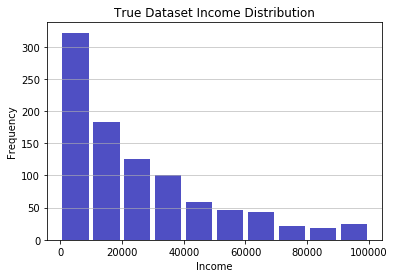

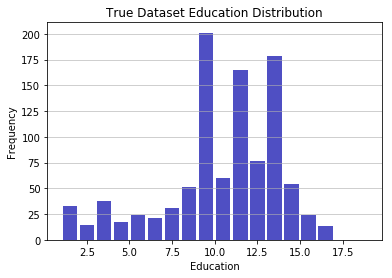

In [69]:
import matplotlib.pyplot as plt


data = np.genfromtxt(data_path, delimiter=',', names=True)
income = list(data[:]['income'])
sex = list(data[:]['sex'])
education = list(data[:]['educ'])

# An "interface" to matplotlib.axes.Axes.hist() method
n_income, bins, patches = plt.hist(income, bins=list(range(0,110000,10000)), color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('True Dataset Income Distribution')
plt.show()

#n, bins, patches = plt.hist(sex, bins=[-0.33,0.33,0.67,1.33], color='#0504aa',
#                            alpha=0.7, rwidth=0.85)
#plt.grid(axis='y', alpha=0.75)
#plt.xlabel('Sex')
#plt.ylabel('Frequency')
#plt.title('True Dataset Sex Distribution')
#plt.show()

n_educ, bins, patches = plt.hist(education, bins=list(range(1,20,1)), color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Education')
plt.ylabel('Frequency')
plt.title('True Dataset Education Distribution')
plt.show()

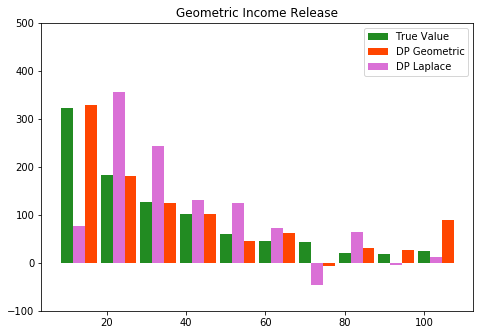

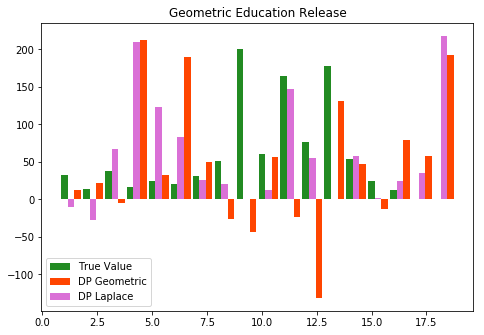

In [75]:
import matplotlib.pyplot as plt



#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#plt.ylim([-100,500])
#inccat = ["10k","20k","30k","40k","50k","60k","70k","80k","90k","100k"]
#ax.bar(inccat, income_histogram.value)
#ax.bar(inccat, income_histogram2.value)
#plt.title("Geometric Income Release")
#plt.show()

#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#plt.ylim([-100,500])
#inccat = ["10k","20k","30k","40k","50k","60k","70k","80k","90k","100k"]
#ax.bar(inccat, income_histogram2.value)
#plt.title("Laplace Income Release")
#plt.show()

#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#sexcat = ["M","F"] # or reversed?
#ax.bar(sexcat, sex_histogram.value)
#plt.show()


#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#edcat = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18"]
#ax.bar(edcat, education_histogram2.value)
#plt.title("Laplace Education Release")
#plt.show()

colorseq = ["forestgreen", "orangered", "orchid"]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylim([-100,500])
#inccat = ["10k","20k","30k","40k","50k","60k","70k","80k","90k","100k"]
inccat = [10,20,30,40,50,60,70,80,90,100]
width=3
inccat_left = [x + 2*width for x in inccat]
inccat_right = [x + width for x in inccat]


ax.bar(inccat, n_income, width=width, color=colorseq[0], label='True Value')
ax.bar(inccat_left, income_histogram.value, width=width, color=colorseq[1], label='DP Geometric')
ax.bar(inccat_right, income_histogram2.value, width=width, color=colorseq[2], label='DP Laplace')
ax.legend()
plt.title("Geometric Income Release")
plt.show()



fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
edcat = list(range(1,19))
width = 0.3
edcat_left = [x + 2*width for x in edcat]
edcat_right = [x + width for x in edcat]

ax.bar(edcat, n_educ, width=width, color=colorseq[0], label='True Value')
ax.bar(edcat_left, education_histogram.value, width=width, color=colorseq[1], label='DP Geometric')
ax.bar(edcat_right, education_histogram2.value, width=width, color=colorseq[2], label='DP Laplace')
ax.legend()
plt.title("Geometric Education Release")
plt.show()




In [70]:
len(n_educ)

18

In [74]:
n_educ



array([ 33.,  14.,  38.,  17.,  24.,  21.,  31.,  51., 201.,  60., 165.,
        76., 178.,  54.,  24.,  13.,   0.,   0.])